In [2]:
from __future__ import division

import time

import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split

In [3]:
%matplotlib inline

In [4]:
iris = load_iris()
x_iris = iris['data']
y_iris = map(lambda x: np.array([1 if i == x else 0 for i in range(3)]),
        iris['target'])
y_iris = np.array(y_iris)

In [13]:
y_iris.shape

(150L, 3L)

In [5]:
sigmoid = np.vectorize(lambda x: 1.0/(1.0+np.exp(-x)))
sig = lambda x: 1.0/(1.0+np.exp(-x))
sig_d = lambda x: sig(x) * (1 - sig(x))
sigmoid_d = np.vectorize(lambda x: sig(x) * (1 - sig(x)))

tanh_d = lambda x: 1 - np.square(np.tanh(x))

In [6]:
def log_loss(y, yhat):
    return np.sum(-(y*np.log(yhat) + (1 - y)*np.log(1 - yhat)))

In [7]:
class neural_network:
    
    def __init__(self, sizes, activation = sigmoid, act_d = sigmoid_d):
        '''
        one required arguement: a list with the layer sizes
        can be used for classification or regression
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(x) for x in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.velocity_biases = [np.zeros(x) for x in sizes[1:]]
        self.velocity_weights = [np.zeros((y, x)) for x, y in
                                 zip(sizes[:-1], sizes[1:])]
        
        self.a = [np.zeros(x) for x in sizes]
        self.a_vec = []
        self.activation = activation
        self.act_d = act_d
        self.z = [np.zeros(x) for x in sizes[1:]]
        self.z_vec = []
        
        
    def predict(self,x):
        self.a_vec = []
        self.z_vec = []
        self.a_vec = [x]
        m = x.shape[0]
        biases = [np.matlib.repmat(b, m, 1) for b in self.biases]
        for w, b in zip(self.weights, biases):
            z = np.dot(w, x.T).T + b
            self.z_vec.append(z)
            x = sig(z)
            self.a_vec.append(x)
        
        return x      
                

    def back_prop(self, x, y):
        '''
        vectorized back propigation
        '''
        nabla_w = [None for l in self.weights]
        nabla_b = [None for l in self.weights]
        deltas = [None for l in self.sizes]
        yhat = self.predict(x)
        deltas[-1] = yhat - y
        for l in range(1, self.num_layers - 1)[::-1]:
            w = self.weights[l]
            a = self.a_vec[l]
            z = self.z_vec[l-1]
            deltas[l] = (np.dot(w.T, deltas[l+1].T) * sig_d(z).T).T
        for l in range(0, self.num_layers-1):
            nabla_w[l] =  np.dot(deltas[l+1].T, self.a_vec[l])
            nabla_b[l] = deltas[l+1]
        return nabla_w, [b.sum(axis = 0) for b in nabla_b]
    

                
    def gradient_descent(self, x, y, lr, Lambda, u):
        '''
        vectorized gradient descent function.
        performas a single gradient descent update on the weights and biases
        lr: learning rate
        Lambda: regularization parameter
        u: velocity coeficient
        '''
        m = len(x)
        delta_weights, delta_biases = self.back_prop(x, y)          
        # update velocity values
        self.velocity_weights = [wv * u - wg/m for wg, wv in
                                 zip(delta_weights, self.velocity_weights)]
        self.velocity_biases = [bv * u - bg/m for bg, bv in 
                                zip(delta_biases, self.velocity_biases)]
        # update parameters
        self.weights = [w + lr * (wv + Lambda * w) for
                        wv, w in zip(self.velocity_weights, self.weights)]
        
        self.biases = [b + lr * bv for bv, b
                        in zip(self.velocity_biases, self.biases)]
        
    
    def fit(self, x, y, batch_size, test_x, test_y,
            learning_rate = 0.01, Lambda = 1e-4,
            velocity_coef = 1, epochs = 1, return_cost = False): 
        '''
        train the neural network using minibatch gradient descent
        '''
        if return_cost:
            cost = []
        for e in xrange(epochs):
#             if e % 4 == 0:
#                 print e
            # create mini batches for minibatch gradient descent
            m = len(x)
            index = np.array(range(m))
            np.random.shuffle(index)
            batch_size = 8
            num_batches = round(m/batch_size,0)
            batches = np.array_split(index, num_batches)
            for batch in batches:
                self.gradient_descent(x[batch], y[batch], learning_rate,
                                      Lambda, velocity_coef)
            if return_cost:
                cost.append(log_loss(test_y, self.predict(test_x)))
        
        if return_cost:
            return cost

In [8]:
digits = load_digits()
X = digits.data
y = digits.target
X -= X.min() # normalize the values to bring them into the range 0-1
X /= X.max()

X_train, X_test, y_train, y_test = train_test_split(X, y)
labels_train = LabelBinarizer().fit_transform(y_train)
labels_test = LabelBinarizer().fit_transform(y_test)

In [35]:
my_nn2 = neural_network([64, 100, 10])

cost2 = my_nn2.fit(X_train, labels_train, batch_size = 10,
                 Lambda = 1e-4, learning_rate = 0.1,
                 epochs = 100, return_cost = True,
                 velocity_coef = 0.2,
                 test_x = X_test,
                 test_y = labels_test)

[[52  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0]
 [ 0  1 41  0  0  0  0  0  0]
 [ 0  0  0 36  0  1  0  0  1]
 [ 0  0  0  0 51  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0]
 [ 0  0  0  0  0  0 40  0  0]
 [ 0  0  0  0  1  0  0 58  1]
 [ 0  1  0  0  0  0  0  0 42]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        52
          1       0.95      1.00      0.97        39
          2       1.00      0.98      0.99        42
          3       1.00      0.92      0.96        39
          4       0.98      1.00      0.99        51
          5       0.98      0.98      0.98        48
          6       1.00      1.00      1.00        40
          7       1.00      0.97      0.98        60
          8       0.93      0.98      0.95        43
          9       0.95      0.97      0.96        36

avg / total       0.98      0.98      0.98       450



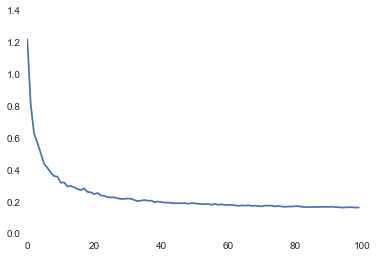

In [36]:
yhat = my_nn2.predict(X_test)
yhat_vec = np.argmax(yhat, axis = 1)
print confusion_matrix(np.argmax(labels_test, axis = 1),
                       yhat_vec, labels = range(9))

print classification_report(np.argmax(labels_test, axis = 1),
                            yhat_vec)
plt.plot(np.array(cost2)/len(labels_test))

In [8]:
import pandas as pd

In [9]:
minst_df = pd.read_csv('C:/Users/jay.swinney/Desktop/minst.csv')
minst = minst_df.values[:,1:]
minst_labels = minst_df['label']

In [10]:
from sklearn.cross_validation import train_test_split

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.metrics import classification_report

In [13]:
minst_train, minst_test, label_train, label_test = train_test_split(
    minst, minst_labels, test_size = 0.2)

In [14]:
minst.shape

(42000L, 784L)

In [15]:
def expand_y(y):
    out = np.zeros(10)
    out[y] = 1
    return out

# expand = np.vectorize(expand_y)

In [16]:
label_test = np.array(map(expand_y,label_test))
label_train = np.array(map(expand_y,label_train))

In [37]:
t0 = time.time()

my_nn = neural_network([784,784/2, 10])
cost = my_nn.fit(minst_train, label_train, batch_size = 10,
                 Lambda = 0, learning_rate = 0.01,
                 epochs = 50, return_cost = True,
                 velocity_coef = 0,
                 test_x = minst_test[0:1000],
                 test_y = label_test[0:1000])

t1 = time.time()
t1 - t0

2280.2249999046326

[[742   0   5   1   2   6  11   1   5]
 [  0 962   4   4   2   4   0   1  11]
 [  5   3 754  12   6   2  11  15  16]
 [  4   4  18 739   2  25   5   3  28]
 [  2   1   5   2 751   2   7   7  10]
 [ 13   3   4  17   6 657  14   3   8]
 [ 11   1   7   2   4  17 774   2   8]
 [  3   4  13   5   6   1   0 809   2]
 [ 12   6   8  24   6  20   3   2 753]]
             precision    recall  f1-score   support

          0       0.93      0.96      0.94       776
          1       0.97      0.97      0.97       988
          2       0.92      0.91      0.92       828
          3       0.90      0.88      0.89       840
          4       0.90      0.92      0.91       813
          5       0.89      0.90      0.89       732
          6       0.94      0.93      0.94       828
          7       0.93      0.94      0.93       861
          8       0.87      0.88      0.88       853
          9       0.89      0.85      0.87       881

avg / total       0.92      0.92      0.92      8400



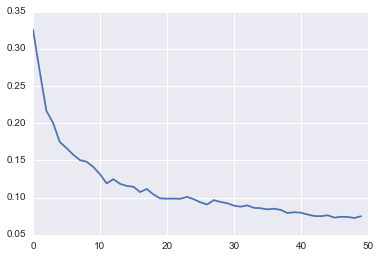

In [38]:
yhat = my_nn.predict(minst_test)
yhat_vec = np.argmax(yhat, axis = 1)
print confusion_matrix(np.argmax(label_test, axis = 1),
                       yhat_vec, labels = range(9))

print classification_report(np.argmax(label_test, axis = 1),
                            yhat_vec)
plt.plot(np.array(cost)/len(label_test))